# Universidad de Chile
### Facultad de Ciencias, Física y Matemáticas
### Departamento de Ciencias de la Computación
### CC5509 - Reconocimiento de Patrones
### Tarea 2 - Optical Character Recognition usando Histogramas de Orientaciones y MultiLayer Perceptron (MLP)
### Gabriel De La Parra

# Introducción
En esta tarea se implementará un OCR para reconocer digitos numéricos utilizando una red neuronal. 

Al igual que en la tarea 1, se trabajará con digitos provenientes de un RUT Chileno. 

Esta tarea se implementó en Jupyter Notebook con Python, debido a la facilidad para ejecutar código, crear un informe y mostrar los resultados en un mismo documento.

La tarea consiste en entrenar una red neuronal de varias capas (MultiLayer Perceptron) para reconocer dígitos. Este tipo de problemas, de determinar un tipo particular de caso, se le conoce como clasificación. 

## Procedimiento

El primer paso para este proyecto consiste en entrenar la red. El entrenamiento de la red consiste en entregarle a la red un conjunto de ejemplos de entrada, indicándole a que corresponde cada ejemplo. Adicional a lo anterior se define la cantidad de capas de la red y algunos parámetros típicos de una red neuronal.

Los ejemplos que se entregarán a la red, en esta tarea se entregarán de dos formas:
1. Histograma de orientaciones (Tarea 1).
2. Imagen Binaria Vectorizada y reducida.

El histograma de orientaciones, como se vió en la tarea 1, consiste en calcular, para cada pixel, el ángulo y la magnitud de la orientación de cambios entre los pixeles vecinos. Se realizaron modificaciones a la tarea 1, esta vez se trabajó con Sobel como fue sugerido anteriormente y con 2 celdas únicamente. También se trabajó con 16 bins en vez de solo 9. Esto dió resultados visiblemente mejores en el histograma.

Con respecto al segundo método, el procesamiento es más sencillo. Se convertirá la imagen a 28x28 pixeles y posteriormente se convertirá a un arreglo plano, sin ningún procesamiento más que la binarización.

Con ambos métodos se procederá a entrenar la red neuronal. Una vez entrenada la red, se guardará el modelo y posteriormente se utilizará para clasificar los dígitos de un RUT.

Dado lo anterior, el procedimiento que se utilizará es el siguiente:
1. Entrenar la red neuronal
    - Procesar las imágenes de entrada según:
        - Histograma de Orientaciones
        - Vector de Imagen Binarizada
    - Entrenar y validar un modelo con distintos parámetros:
        - Cantidad de neuronas ocultas: 
            - 10
            - 20
            - 30
            - 40
            - 50
        - Función de activación:
            - Sigmoidal (logistic)
            - TanH
            - RELU
2. Guardar el modelo entrenado usando joblib de sklearn.externals
3. Clasificar los dígitos de la imagen

# Imports

In [1]:
# Tarea 1
import numpy as np
import math
import os
from scipy import ndimage, signal, misc
from skimage import io, morphology, filters, segmentation, measure, color
from matplotlib import pyplot as plt, patches
import pandas as pd
%matplotlib inline

# Tarea 2
from sklearn.neural_network import MLPClassifier
from sklearn.externals import  joblib

# Refactor Tarea 1
En esta parte se trabajará sobre los resultados de la tarea 1. Se extraerán los métodos para el procesamiento de los dígitos que crean los histogramas de orientaciones. 

Se ha hecho una modificación sobre la tarea anterior, dejando 2x2 celdas por cada imagen (En la tarea anterior se trabajó con 4x4), el procesamiento era mayor, pero en este caso los resultados son más apropiados para el trabajo con todas las imágenes.

El procesamiento de los dígitos da como resultado un vector de 36 valores, correspondiente a los 9 bins por 4 celdas en cada imagen. 

Otra mejora, fue agregar un threshold para aceptar un valor en magnitud. Si la magnitud de cambio entre 2 pixeles no es mayor que dicho umbral, no se toma ese pixel para el histograma. Esto fue una recomendación del profesor.

Como se mencionó anteriormente, las imágenes se han reducido a 16x16 para acelerar el proceso de procesamiento en la fase de pruebas. Esto solo para la primera parte del informe, para la versión final, se trabajará con el tamaño completo de la imagen.

In [2]:
nBins = 16
magnitudeThreshold = 0.1
assignment = "soft"

In [3]:
def getOrientAndMags(image):
    gradX = filters.sobel_h(image)
    gradY = filters.sobel_v(image)
    o = (np.arctan2(gradY, gradX)  * 180 / np.pi) % 360
    m = np.sqrt(gradY**2 + gradX**2)
    return o, m

In [4]:
def getDigitHistogram(image, bins, assignment = "soft", threshold = 0.1):
    hist = np.zeros(bins, dtype=np.float32)
    w, h = image.shape
    
    o, m = getOrientAndMags(image)
    maxVal = np.max(m) * np.max(o)
    
    for i in range(w):
        for j in range(h):
            # Skip those with magnitude lower than 'threshold'.
            if(m[i,j] > threshold):
                calc = (o[i,j] * m[i,j])
                if(assignment == "hard"):
                    kbin = int(round(calc/maxVal*(bins-1)))
                    hist[kbin] += 1.0
                else:
                    b = calc/maxVal*(bins-1)
                    if(math.isnan(b)):
                        b = 0
                    dist = b - math.floor(b)
                    lbin = math.floor(b)
                    rbin = math.ceil(b)
                    if(dist < 0.5):
                        lw = 0.5 - dist
                        rw = 1-lw
                    else:
                        rw = dist - 0.5
                        lw = 1 - rw
                    hist[lbin] += lw
                    hist[rbin] += rw
    return hist

In [5]:
def fixImagePadding(image, cellSize = (4,4)):
    w, h = image.shape
    cX, cY = cellSize
    padX = cX - (w % cX)
    padY = cY - (h % cY)
    if(padX == cX): padX = 0
    if(padY == cY): padY = 0
    paddedImage = np.zeros((w+padX, h+padY))
    paddedImage.fill(255)
    for x in range(w):
        for y in range(h):
            paddedImage[x,y] = image[x,y]
    return paddedImage

In [6]:
def getImageCells(image, cellSize = (4,4)):
    cells = []
    w, h = image.shape
    cX, cY = cellSize
    for x in range(int(w/cX)):
        for y in range(int(h/cY)):
            cells.append(image[x*cX:((x+1)*cX), y*cY:((y+1)*cY)])

    return cells  

In [7]:
def concatenateCellsDescriptors(cells):
    concat = []
    for cell in cells:
        hist = getDigitHistogram(cell, bins = nBins, assignment = assignment, threshold = magnitudeThreshold)
        for h in hist:
            concat.append(h)
    return concat

In [8]:
def plotCellDescriptors(concat, cells):
    plt.figure(figsize=(30,10))
    concat = concatenateCellsDescriptors(cells)
    plt.bar(np.arange(len(concat)), concat)
    plt.show()

In [9]:
def resizeAndGetDigitHistogramDescriptor(digitFilename, w = 0, h = 0, cW = 0, cH = 0, verbose = True):
    digit=io.imread(digitFilename)
    digitImage = digit
    if(w>0 and h >0):
        digit = misc.imresize(digit, (w, h))
    if(cW>0 and cH>0):
        digit = fixImagePadding(digit, (cW, cH))
    else:
        cW, cH = digit.shape
    cells = getImageCells(digit, (cW, cH))
    concat = concatenateCellsDescriptors(cells)
    
    if(verbose):
        plt.imshow(digit, cmap="gray")
        print("ImageFilename:", digitFilename)
        print("original:", digitImage.shape, "Resize and padded:", digit.shape)
        print("Concatenated histogram length:", len(concat))
        plotCellDescriptors(concat, cells)
    
    return np.array(concat), cells

ImageFilename: ./digits_K/train/chr_0/img001-00001.png
original: (128, 128) Resize and padded: (128, 128)
Concatenated histogram length: 32


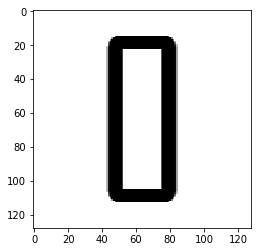

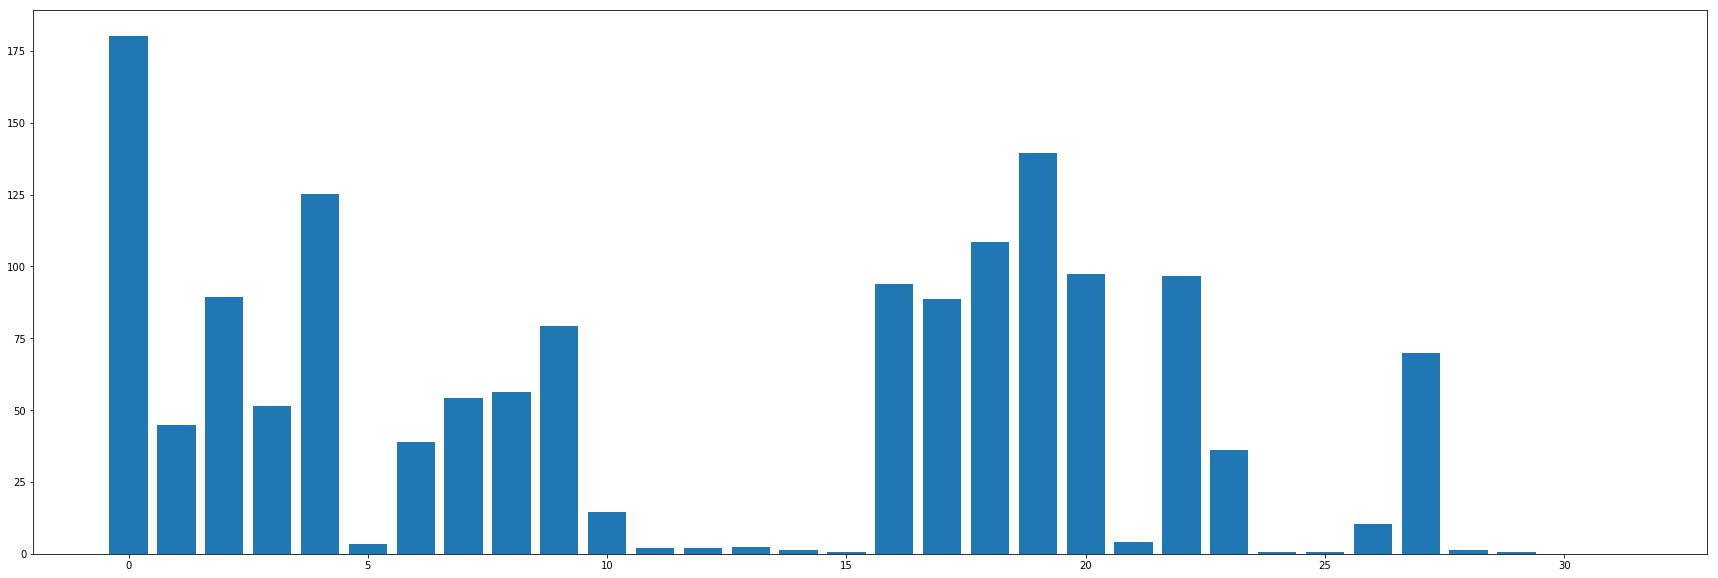

In [10]:
sampleDigitFilename = "./digits_K/train/chr_0/img001-00001.png"
concat, cells = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 0,0,128,64,verbose = True)

ImageFilename: ./digits_K/train/chr_1/img002-00004.png
original: (128, 128) Resize and padded: (128, 128)
Concatenated histogram length: 32


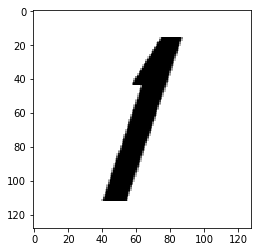

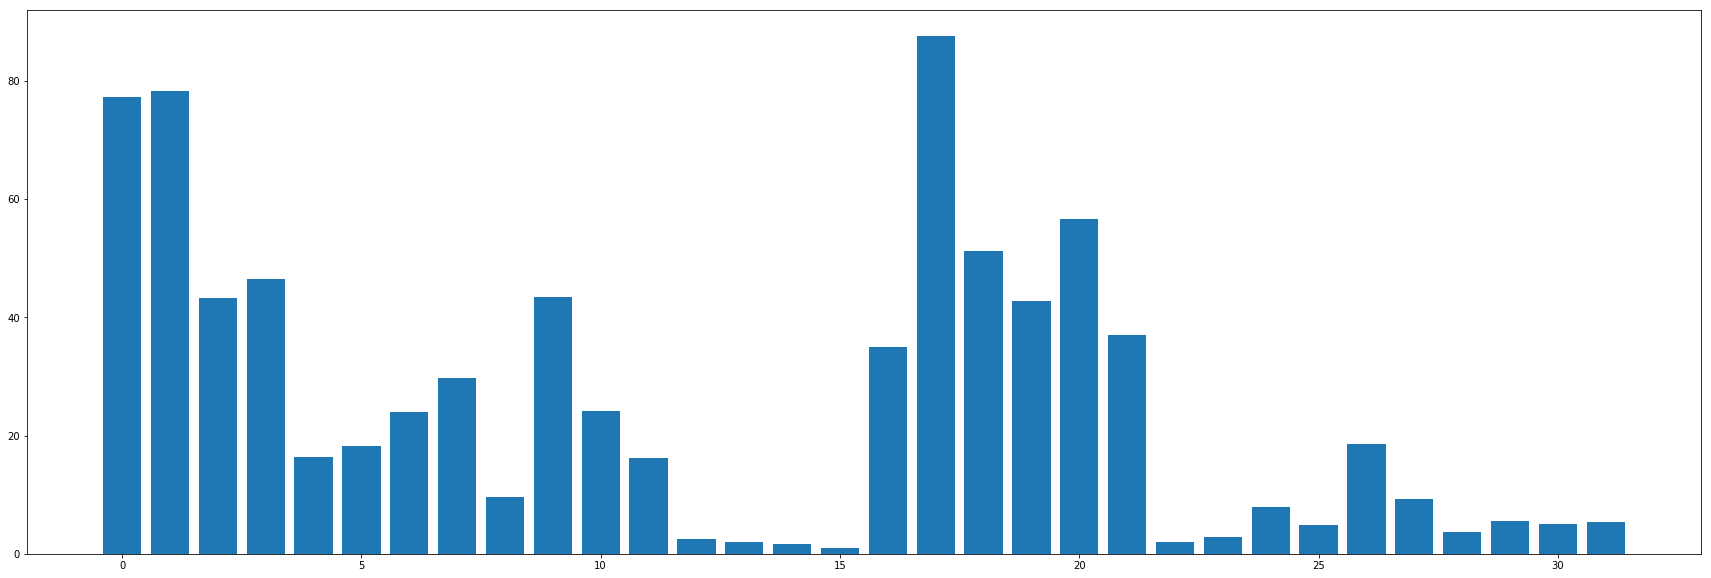

In [11]:
sampleDigitFilename = "./digits_K/train/chr_1/img002-00004.png"
concat, cells = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 0,0,128,64,verbose = True)

ImageFilename: ./digits_K/train/chr_2/img003-00003.png
original: (128, 128) Resize and padded: (128, 128)
Concatenated histogram length: 32


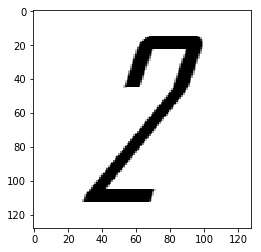

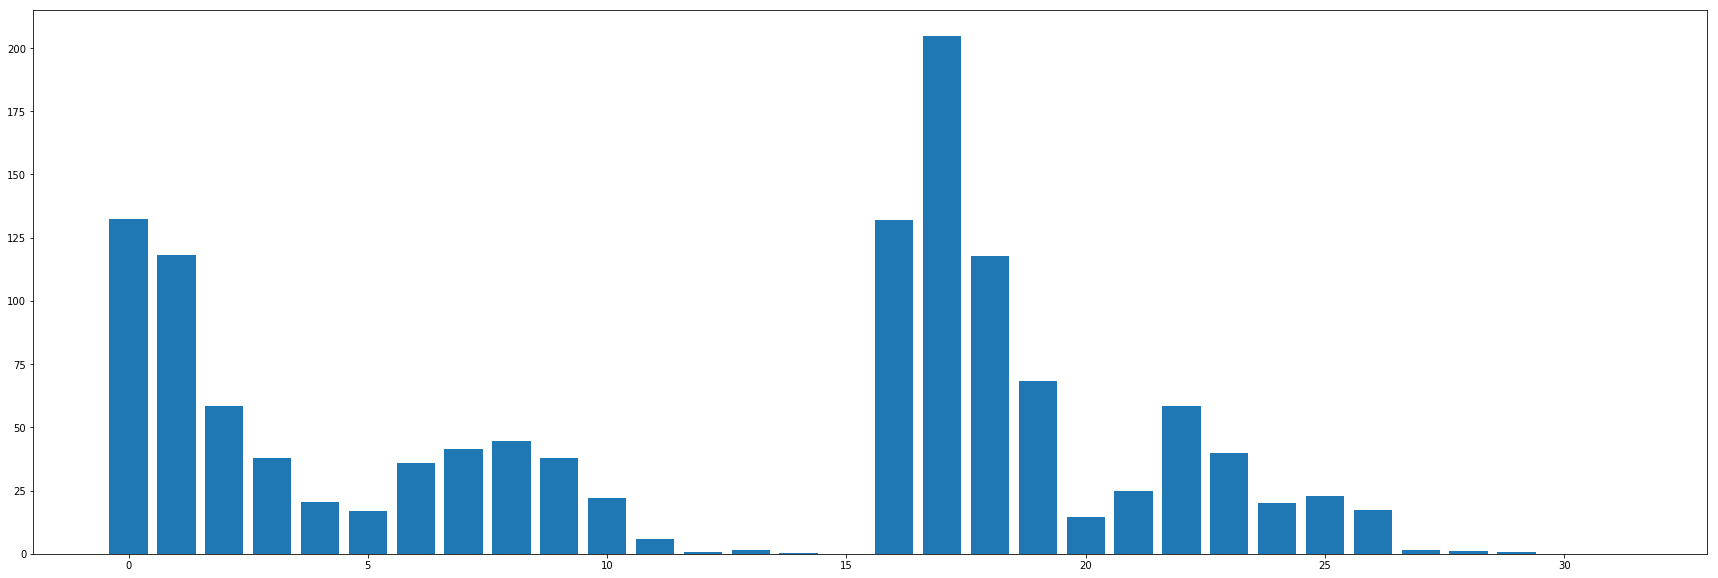

In [12]:
sampleDigitFilename = "./digits_K/train/chr_2/img003-00003.png"
concat, cells = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 0,0,128,64,verbose = True)

ImageFilename: ./digits_K/train/chr_6/img007-00001.png
original: (128, 128) Resize and padded: (128, 128)
Concatenated histogram length: 32


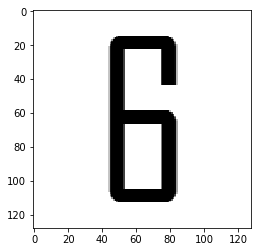

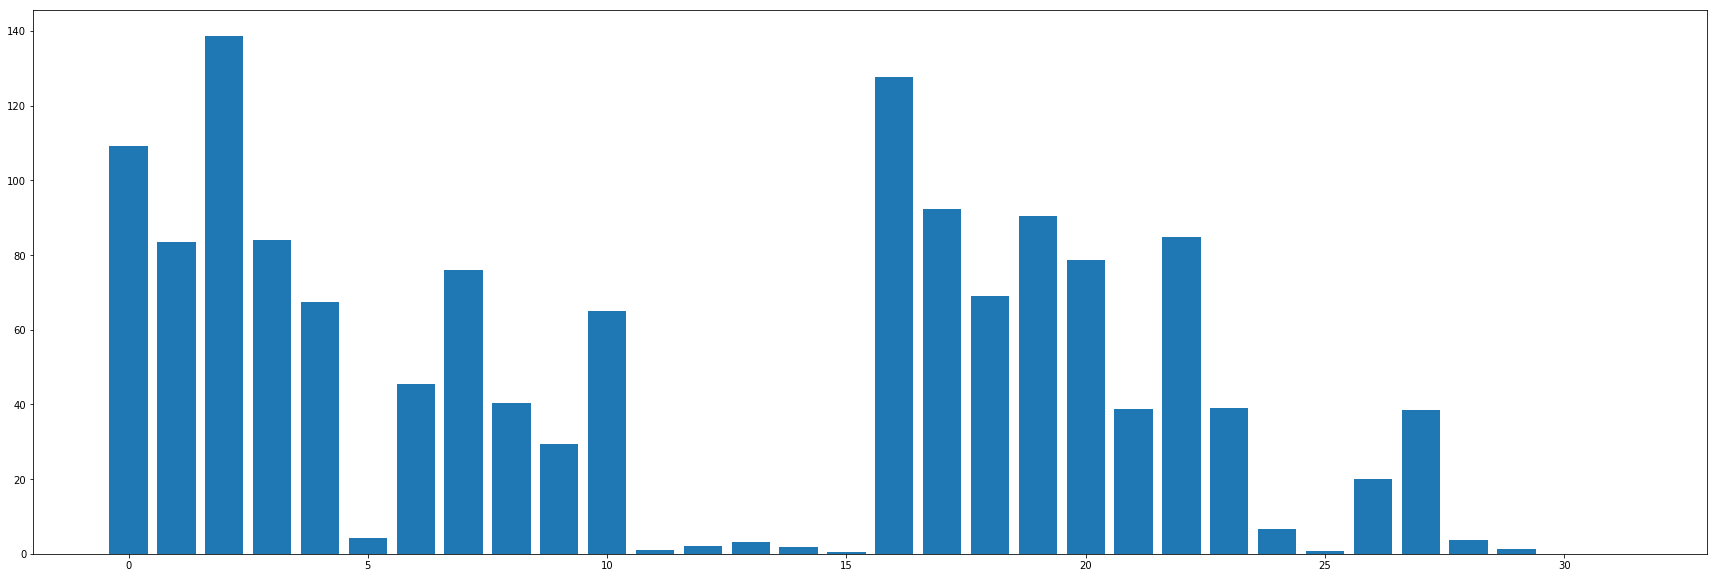

In [13]:
sampleDigitFilename = "./digits_K/train/chr_6/img007-00001.png"
concat, cells = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 0,0,128,64,verbose = True)

ImageFilename: ./digits_K/train/chr_9/img010-00001.png
original: (128, 128) Resize and padded: (128, 128)
Concatenated histogram length: 32


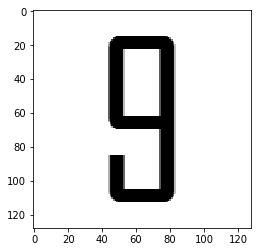

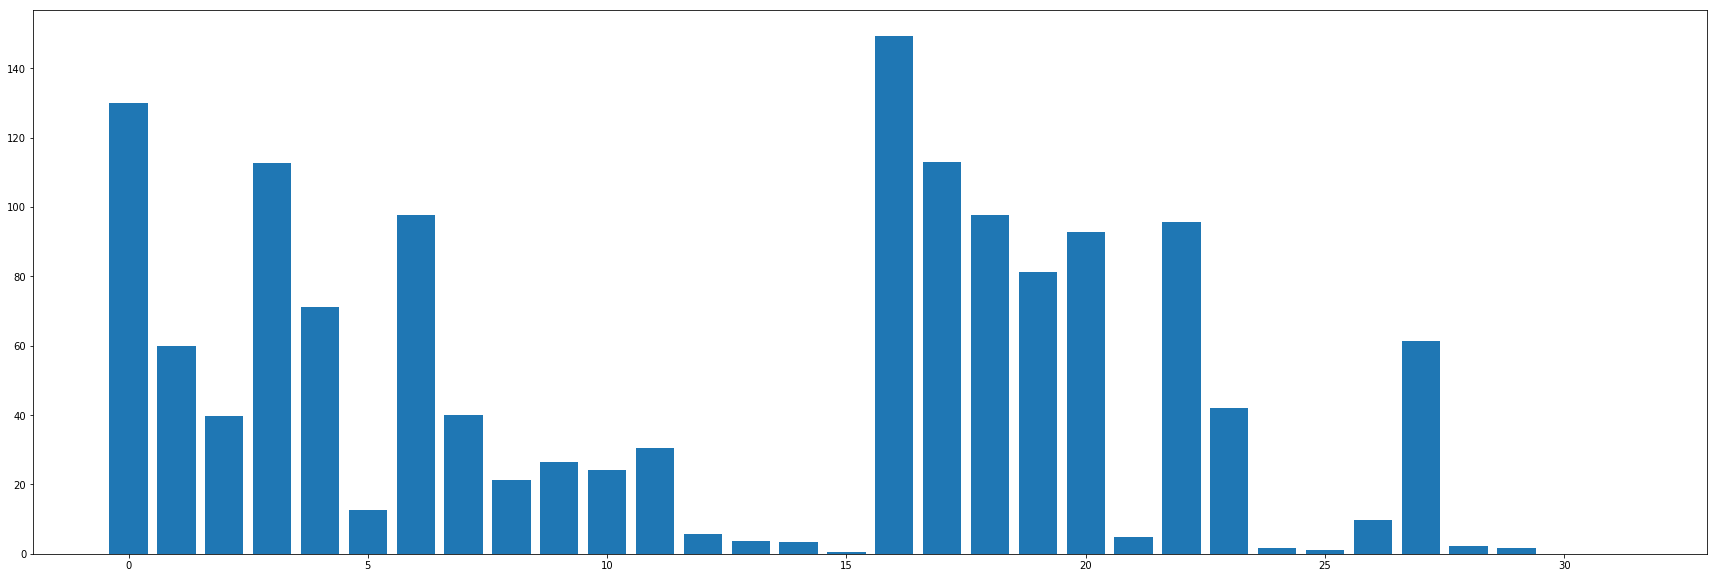

In [14]:
sampleDigitFilename = "./digits_K/train/chr_9/img010-00001.png"
concat, cells = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 0,0,128,64,verbose = True)

In [15]:
histogram, _ = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 0, 0,  128,64, verbose = False)
histogram

array([ 129.94969177,   59.92780304,   39.65537643,  112.78340912,
         71.13985443,   12.53761101,   97.59048462,   39.88760376,
         21.19080734,   26.43832016,   24.10162926,   30.53834534,
          5.64153337,    3.73558831,    3.34693122,    0.5350154 ,
        149.23851013,  113.07494354,   97.58656311,   81.20097351,
         92.7702713 ,    4.73376179,   95.75830078,   42.0747757 ,
          1.56189251,    1.10362148,    9.65533066,   61.31290817,
          2.37156343,    1.55651724,    0.        ,    0.        ], dtype=float32)

In [16]:
def getNormalizedHistogram(histogram):
    histSum = np.sum(histogram)
    return histogram/histSum

In [17]:
getNormalizedHistogram(histogram)

array([ 0.09068366,  0.04181982,  0.02767298,  0.0787044 ,  0.049644  ,
        0.00874921,  0.06810223,  0.02783503,  0.01478772,  0.01844963,
        0.016819  ,  0.02131078,  0.00393687,  0.00260683,  0.00233561,
        0.00037335,  0.10414411,  0.07890785,  0.06809948,  0.05666502,
        0.0647385 ,  0.00330339,  0.06682365,  0.02936132,  0.00108995,
        0.00077015,  0.00673784,  0.0427864 ,  0.00165496,  0.00108619,
        0.        ,  0.        ], dtype=float32)

# Imagen a Vector Binarizado
Se convertirá a la imagen a 28x28 pixeles, se aplicará un Threshold Otsu y se hará un Reshape a un vector de una sola fila.

In [18]:
def getImageVector(digitFilename, w = 28, h = 28):
    digitImage=io.imread(digitFilename)
    digit = misc.imresize(digitImage, (w, h))
    th=filters.threshold_otsu(digit*0.95)
    digit = digit > th
    return np.reshape(digit, w*h)

In [19]:
sampleDigitFilename = "./digits_K/train/chr_0/img001-00001.png"
getImageVector(sampleDigitFilename)[::20]

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True], dtype=bool)

# Entrenamiento de la MLP
Una vez que se tiene completo el procesamiento de los dígitos, será necesario entrenar la Red Neuronal.

## Get Training Images

In [20]:
def getfiles(folder, extension):
    images = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in [f for f in filenames if f.endswith(extension)]:
            images.append(os.path.join(dirpath, filename))
    return images

In [21]:
def getTrainFiles():
    return getfiles("./digits_K/train/", ".png")

def getValidFiles():
    return getfiles("./digits_K/valid/", ".png")

In [22]:
trainImageFilenames = getTrainFiles()
validImageFilenames = getValidFiles()
print("Train:", len(trainImageFilenames), "Valid:", len(validImageFilenames))

Train: 6600 Valid: 2200


In [23]:
trainImageFilenames[0]

'./digits_K/train/chr_0\\img001-00001.png'

## Create Labels for Test/Valid Images

In [24]:
def getImageLabel(filename, index):
    return filename[index]

def getTestImageLabel(filename):
    return getImageLabel(filename, 21)

def getValidImageLabel(filename):
    return getImageLabel(filename, 21)

In [25]:
getTestImageLabel(trainImageFilenames[0])

'0'

In [26]:
def toLabelVector(values):
    return pd.get_dummies(values).values

In [27]:
def getFileSet(filenames, function):
    for filename in filenames:
        result = function(filename)
        yield result
        
def getTestFileLabels(filenames):
    return toLabelVector(getFileSet(filenames, getTestImageLabel))

def getValidFileLabels(filenames):
    return toLabelVector(getFileSet(filenames, getValidImageLabel))

In [28]:
train_target = getTestFileLabels(trainImageFilenames)
train_target[::659]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [29]:
test_target = getValidFileLabels(validImageFilenames)
test_target[::219]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

## Test Set Assembly

In [30]:
def getHistogram(filename):
    histogram, _ = resizeAndGetDigitHistogramDescriptor(filename, 16, 16, 8, 16, verbose = False)
    #return getNormalizedHistogram(histogram)
    return histogram

def getHistogramFileSet(filenames):
    return getFileSet(filenames, getHistogram)

def getVectorFileSet(filenames):
    return getFileSet(filenames, getImageVector)

In [31]:
histogram_train_data = np.stack(getHistogramFileSet(trainImageFilenames))

In [192]:
vector_train_data = np.stack(getVectorFileSet(trainImageFilenames))

# Train Neural Network

In [187]:
vector_test_data = np.stack(getVectorFileSet(validImageFilenames))

In [34]:
histogram_test_data = np.stack(getHistogramFileSet(validImageFilenames))

In [188]:
layerSize = 50
activation = "relu"

In [189]:
mlp = MLPClassifier(activation=activation, hidden_layer_sizes=(layerSize,), max_iter=5000, alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, learning_rate_init=.01)

In [193]:
mlp.fit(vector_train_data, train_target)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=0, warm_start=False)

# Validate Results

In [194]:
score = int(round(mlp.score(vector_test_data, test_target)*100))

In [195]:
print('Testing accuracy: {} '.format(score)) 

Testing accuracy: 94 


In [196]:
joblib.dump(mlp, 'mlp_orientation_'+activation+'_'+str(layerSize)+'_score-'+str(score)+'_'+'.model')

['mlp_orientation_relu_50_score-94_.model']

# Probar con RUT

In [197]:
def getImageDigits(imageFilename):
    digits = []
    #Read
    image=io.imread(imageFilename)
    #Threshold
    th=filters.threshold_otsu(image*0.95)
    im_bin = image > th
    
    #Regions:
    mlabels, nlabels = morphology.label(1-im_bin, connectivity=1, return_num=True)
    regions = measure.regionprops(mlabels)
    
    #Regions of Interest
    roiList = []
    for i in range(1, nlabels + 1):
        px, py = ndimage.find_objects(mlabels==i)[0]
        roiList.append((px,py))
        
    #Sort regions by position:
    sortedRoi = sorted(roiList, key= lambda x: x[1])
    
    # Filter small Regions, Pad results:
    for j in range(nlabels):
        (px, py) = sortedRoi[j]
        if(getSliceTupleArea((px,py))>15):
            roi = im_bin[px, py].astype(int)*255
            #roi = np.pad(roi, 2, mode='constant', constant_values=1)
            digits.append(roi)
    
    #return
    return digits


In [198]:
def getSliceTupleArea(sliceTuple):
    return (sliceTuple[0].stop - sliceTuple[0].start) * (sliceTuple[1].stop - sliceTuple[1].start)

In [199]:
def resizeAndGetDigitHistogramDescriptor(digit, w = 0, h = 0, cW = 0, cH = 0):
    digitImage = digit
    if(w>0 and h >0):
        digit = misc.imresize(digit, (w, h))
    if(cW>0 and cH>0):
        digit = fixImagePadding(digit, (cW, cH))
    else:
        cW, cH = digit.shape
    cells = getImageCells(digit, (cW, cH))
    concat = concatenateCellsDescriptors(cells)
    
    return np.array(concat), cells

In [204]:
digits = getImageDigits("./test-images/rut_1.png")
for digit in digits:
    digit = misc.imresize(digit, (28, 28))
    th=filters.threshold_otsu(digit*0.95)
    digit = digit > th
    digit = np.reshape(digit, 28*28)
    #histogram, _ = resizeAndGetDigitHistogramDescriptor(digit, 128, 32, 32, 32)
    digitScore = mlp.predict(digit)
    print(digitScore)

[[0 0 0 1 0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0 1 0 0 1]]
[[0 1 0 0 1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 1 1]]
[[0 0 1 1 0 0 0 1 0 0 0]]
[[0 0 0 1 0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0 1 0 0 0]]
[[0 0 0 1 0 0 0 1 0 1 0]]
[[0 0 0 0 0 1 1 0 0 0 1]]


c:\anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
c:\anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
c:\anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
c:\anaconda3\lib\site-packages\

# Conclusiones y Resultados

En este proyecto se han entrenado varias redes neuronales con distintos parámetros y distintos Feature Vectors (Histograma y Vectorización Binaria + Reducción).

Se puede apreciar de los resultados, que trabajar con una red con menos neuronas, conlleva en la mayoría de los casos a peores resultados pero tiempos de entrenamientos mayores.

Al entrenar con 10 neuronas, muchas veces el entrenamiento concluía de forma abrupta al llegar a avanzar bajo la tolerancia. Esto sin embargo, como se puede apreciar en los modelos de entrenamiento, es variable ya que como se vió en clases, los pesos iniciales determinan en gran medida el entrenamiento de la red. Al tomarse estos al azar, puede llegar a encontrarse un mínimo global o un mínimo local. Al entrenarse la red con más neuronas, la probabilidad de encontrar máximos globales es más alta.

Algunos resultados obtenidos (utilizando el método de los vectores) que apoyan lo anterior fueron:
- RELU, 10 neuronas, 29%
- RELU, 10 neuronas, 45%
- RELU, 10 neuronas, 82%
- RELU, 10 neuronas, 85%

Los resultados sobre las funciones de activación no fueron del todo desicivos. Se puede apreciar que varios intentos de entrenamiento con 10 neuronas y distintas funciones de activación fueron diferentes:
- Log  ~0%-48%, 
- RELU ~30%-85% 
- TANH ~0%-52%

De todas formas, como se mencionó anteriormente, estos podrían bien ser casualidad ya que se encontró que los resultados fueron bastante similares con 50 neuronas y se podría estimar que los tiempos de entrenamiento también son similares. Se considera que se requeriría de ejemplos con más clases y más dimensiones para determinar correctamente cuál de las tres funciones de activación entrega mejores resultados.

Los resultados obtenidos para los dos métodos son mejores a los obtenidos en la tarea 1. Esto principalmente a que se tenían más ejemplos para entrenamiento que en la vez pasada. En la tarea 1 se entrenó una clasificador con 40 ejemplos, en este caso 6600 ejemplos para pruebas. De lo mismo, sin una experimentación más amplia no se podría indicar directamente si para esta aplicación en específico, un resultado es mejor que otro.

Un problema que se tuvo fue entrenar con el vector de orientaciones. Los resultados no fueron para nada satisfactorios.

Los mejores resultados que se tuvieron con éste método fueron:
- Logistic, 50, 61%
- RELU, 50, 55%
- TanH, 50, 60%

Lo anterior se supone por varias cosas:
Los vectores de entrada eran muchos más pequeños, la imagen vectorizada era un vector de entrada de 768 valores, mientras que en el caso de las orientaciones se trabajó con 16 bins y 2 celdas, osea, 32 valores de entrada. 

Entrenar la red neuronal tomó mucho más tiempo. Si bien esto no afecta en los resultados, finalmente, para poder entregar resultados se trabajó con una reducción del tamaño de las imágenes. Esto en parte debido a que el procesamiento de las imágenes trabajaba con imágenes mucho más grandes (128x128 pixeles). Se modificó el código de la tarea 1 según los comentarios realizados post-entrega, sin embargo, los resultados sin reducir los tamaños de las imágenes requirieron más tiempo y de esta manera, no se pudo experimentar tanto como con el otro método. 